In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import json
sns.set_style("whitegrid")

from constants import LOCATION_CHOOSEN, OUTPUT_DIR, DATA_CACHE_DIR, OPTIMAL_VALUES_FILE

In [2]:
data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel("owid-covid-data.xlsx")
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

df['date'] = pd.to_datetime(df['date'])
# creating new columns
df['N'] = df['population']
df['S'] = df['population'] - (df['total_cases'] + df['people_fully_vaccinated'])
df['I'] = df['total_cases']
df['R'] = df['people_fully_vaccinated']

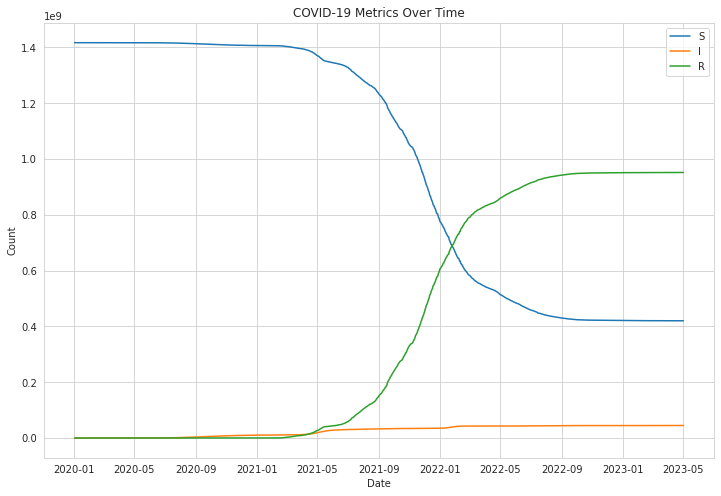

In [3]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S'], label='S')
plt.plot(df['date'], df['I'], label='I')
plt.plot(df['date'], df['R'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [4]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def compute_cost(data, predictions):
    n = len(data)
    return (100 / n) * np.sum(np.abs((data - predictions) / data))

def compute_cost(data, predictions):
    return np.sum(np.square(data - predictions))

def compute_cost(data, predictions):
    return np.abs(data - predictions).mean()

def integrate_system(params, y0, t, N):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [5]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

In [6]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(optimal_beta, optimal_gamma)
print(optimal_beta/optimal_gamma)

0.07311369954074455 0.044111538344129904
1.6574733569788114


In [7]:
ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma))
S, I, R = ret.T

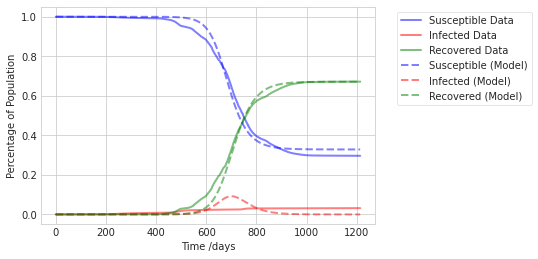

In [8]:
plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_fit_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [9]:
cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(cost)

74733884.22167633


In [10]:
def deriv_2(y, t, N, beta_array, gamma):
    S, I, R = y
    t = min(int(t), len(beta_array) - 1)
    dSdt = -beta_array[t] * S * I / N
    dIdt = beta_array[t] * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
    
def time_varying_beta(optimal_beta, stringency_weight, stringency_index):
    beta = optimal_beta + (stringency_weight * stringency_index)
    return beta

def objective_function_2(params, y0, t, N, df, gamma, all_stringencies):
    stringency_weight = params[0]
    
    beta_array = time_varying_beta(optimal_beta, stringency_weight, all_stringencies)
    
    predictions = odeint(deriv_2, y0, t, args=(N, beta_array, gamma))
    S, I, R = predictions.T
    
    cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
    return cost

# Set initial values
initial_guess_for_stringency_weight = [0.01]
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)
current_stringency = df['stringency_index'].values

# Perform the optimization
result = minimize(
    objective_function_2,
    initial_guess_for_stringency_weight,
    args=(y0, t, N, df, optimal_gamma, current_stringency),
    method='Nelder-Mead',
)

optimal_stringency_weight = result.x[0]
print(f"Optimal stringency weight: {optimal_stringency_weight}")

Optimal stringency weight: -4.307369509681814e-11


In [11]:
store_S = []
store_I = []
store_R = []

def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

for ith_day in range(0, days_difference + 1):
    t = np.linspace(0, ith_day, ith_day+1)
    stringency_index = df['stringency_index'].iloc[ith_day]
    beta_for_stringency = time_varying_beta(optimal_beta, optimal_stringency_weight, stringency_index)
    predictions = odeint(deriv, y0, t, args=(N, beta_for_stringency, optimal_gamma))
    S, I, R = predictions.T
    store_S.append(S[-1])
    store_I.append(I[-1])
    store_R.append(R[-1])

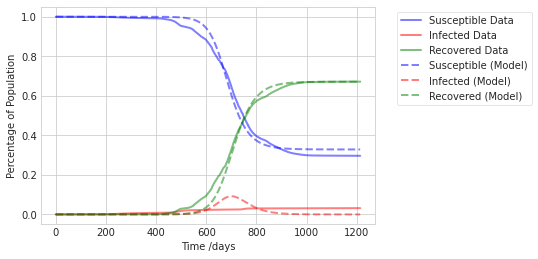

In [12]:
plt.figure()
plt.plot(t, df['S']/N, 'b', alpha=0.5, lw=2, label='Susceptible Data')
plt.plot(t, df['I']/N, 'r', alpha=0.5, lw=2, label='Infected Data')
plt.plot(t, df['R']/N, 'g', alpha=0.5, lw=2, label='Recovered Data')

plt.plot(t, store_S/N, 'b--', alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(t, store_I/N, 'r--', alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(t, store_R/N, 'g--', alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Time /days')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_beta_varying_fit_" + LOCATION_CHOOSEN + ".png"))
plt.show()

In [13]:
stringency_optimized_cost = compute_cost(df['S'], store_S) + compute_cost(df['I'], store_I) + compute_cost(df['R'], store_R)
print(stringency_optimized_cost)

74733884.09450117


In [14]:
print(cost - stringency_optimized_cost)

0.12717516720294952


In [15]:
optimal_values = {
    'optimal_beta': optimal_beta,
    'optimal_gamma': optimal_gamma,
    'optimal_stringency_weight': optimal_stringency_weight
}

with open(OPTIMAL_VALUES_FILE, "w") as outfile: 
    json.dump(optimal_values, outfile)

In [16]:
print(min(t), max(t))

0.0 1214.0


In [17]:
betas = time_varying_beta(optimal_beta, optimal_stringency_weight, df['stringency_index'])
r0 = betas/optimal_gamma

df["S_modelled"] = store_S
df["I_modelled"] = store_I
df["R_modelled"] = store_R
df["r_eff_actual"] = r0 * df["S"]/df["N"]
# df["reward_actual"] = df["gdp_normalized"] / df["r_eff_actual"]

In [18]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))

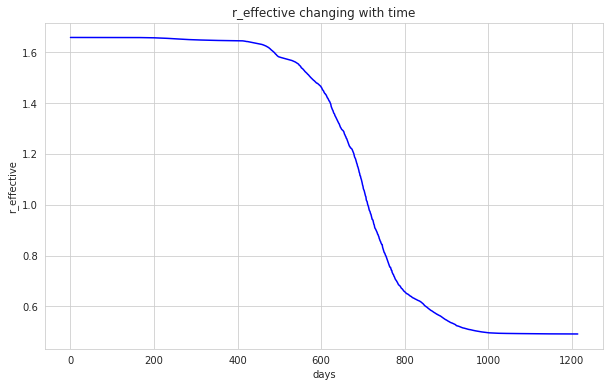

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df["r_eff_actual"], color='b')
plt.xlabel('days')
plt.ylabel('r_effective')
plt.title('r_effective changing with time')
plt.show()

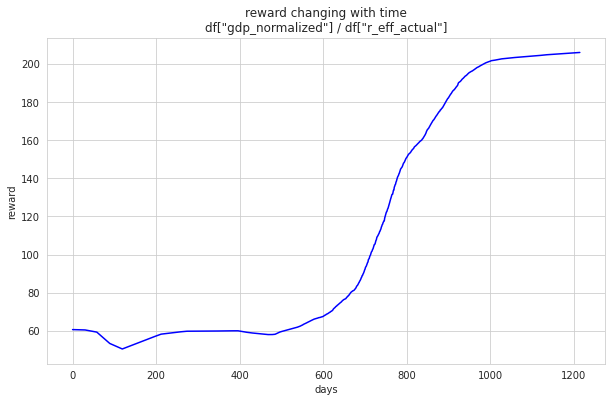

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df['gdp_normalized'] / df['r_eff_actual'], color='b')
plt.xlabel('days')
plt.ylabel('reward')
plt.title('reward changing with time\ndf["gdp_normalized"] / df["r_eff_actual"]')
plt.show()

In [21]:
df.diff()['stringency_index'][1:].describe()

count    1214.000000
mean        0.023641
std         2.203523
min       -14.360000
25%         0.000000
50%         0.000000
75%         0.000000
max        55.560000
Name: stringency_index, dtype: float64

In [22]:
inertia_rewards = [0]
for i in range(1, len(df)):
    diff = df['stringency_index'][i] - df['stringency_index'][i - 1]
    inertia_reward = 10 if diff == 0 else 0
    inertia_rewards.append(inertia_reward)

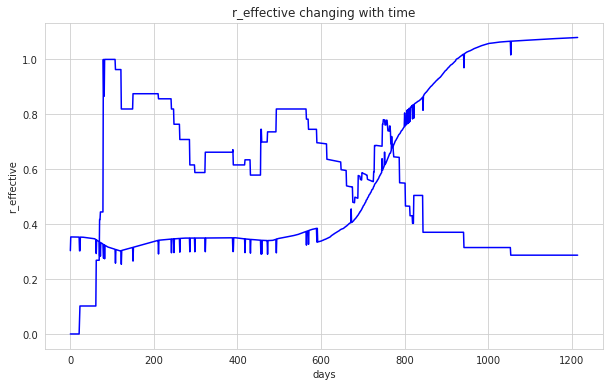

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(df['gdp_normalized'] / df['r_eff_actual'] + inertia_rewards) / 200, color='b')
plt.plot(df['stringency_index'] / 100, color='b')
plt.xlabel('days')
plt.ylabel('r_effective')
plt.title('r_effective changing with time')
plt.show()

In [24]:
r_eff_rewards = []
for i in range(0, len(df)):
    r_eff = df['r_eff_actual'][i]
    r_eff_reward = 20 if r_eff <= 1 else 0
    r_eff_rewards.append(r_eff_reward)

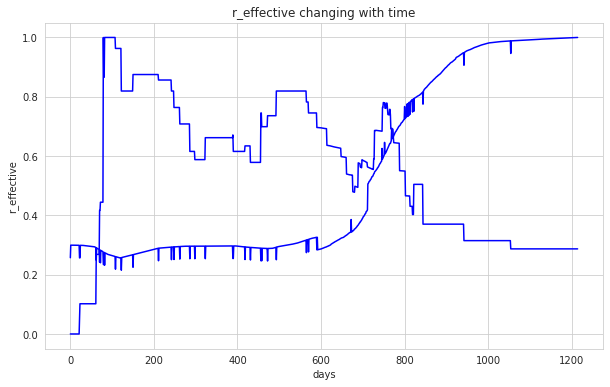

In [25]:
plt.figure(figsize=(10, 6))

total_rewards = np.array(df['gdp_normalized'] / df['r_eff_actual'] + inertia_rewards + r_eff_rewards)
plt.plot(total_rewards / max(total_rewards), color='b')
plt.plot(df['stringency_index'] / 100, color='b')
plt.xlabel('days')
plt.ylabel('r_effective')
plt.title('r_effective changing with time')
plt.show()

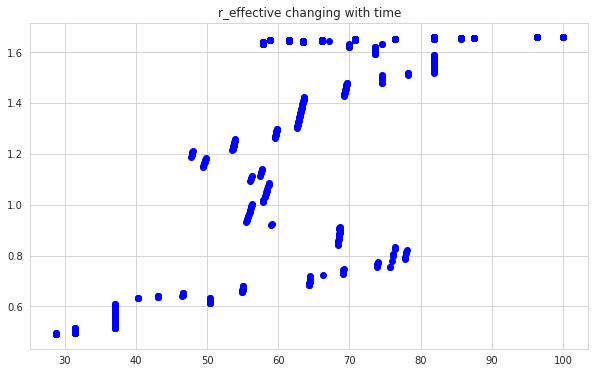

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(df['stringency_index'][100:], df['r_eff_actual'][100:], color='b')
plt.title('r_effective changing with time')
plt.show()

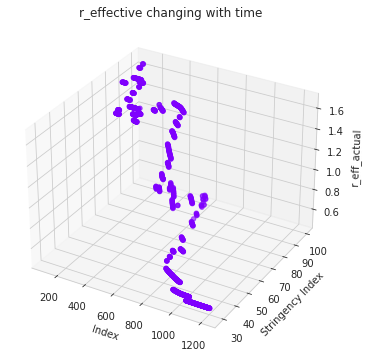

In [27]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with df['stringency_index'], df['r_eff_actual'], and df.index
ax.scatter(df.index[100:], df['stringency_index'][100:], df['r_eff_actual'][100:], color='#7F00FF')

ax.set_xlabel('Index')
ax.set_ylabel('Stringency Index')
ax.set_zlabel('r_eff_actual')

plt.title('r_effective changing with time')
plt.show()